# Initial Block

In [1]:
import os
import glob
import time
import joblib
from getpass import getpass
from google.colab import drive





drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/coco_segment/")

print("DO NOT LEAVE ./coco_segment  directory")
print("Switched to ",os.getcwd())


########################
### switch directory ###
########################

def switch_directory(ip=None, getPath=False, verbose=False):
  d = {}

  l = [
      "/content/drive/My Drive/coco_segment/", #0
      "/content/drive/My Drive/coco_segment/coco_seg/", #1
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/", #2
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/1CH_train_masks/", #3
      "/content/drive/My Drive/coco_segment/coco_seg/picklefiles/1CH_val_masks/", #4
      "/content/drive/My Drive/coco_segment/data/coco/annotations/instances_train2017.json", #5
      "/content/drive/My Drive/coco_segment/data/coco/annotations/instances_val2017.json", #6
  ]

  for x,i in enumerate(l):
      d[x] = i
      if verbose:
        print(x, i)
  
  d["root"] = "/content/drive/My Drive/"
  
  
  if getPath:
    return d[ip]
  
  
  if ip == None:
    
    # print(d)

    ip = int(input("Enter path number "))
    os.chdir(d[ip])
  
  else:
    os.chdir(d[ip])  
    
  
  print("Switched to: ", os.getcwd())
  
  return os.getcwd()

switch_directory(1)

Mounted at /content/drive
DO NOT LEAVE ./coco_segment  directory
Switched to  /content/drive/My Drive/coco_segment
Switched to:  /content/drive/My Drive/coco_segment/coco_seg


'/content/drive/My Drive/coco_segment/coco_seg'

In [0]:
! mkdir -p ./logs/fit/
! rm -rf ./logs/fit
! ls ./logs

# Libraries

In [3]:
import pandas as pd
import numpy as np
import json


import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from glob import glob
from datetime import datetime


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


# Custom Libraries

In [4]:
switch_directory(1)
from loadData import CocoHelper, LoadBin



dataDir = "../data/coco/"

# (dataDir='../data/coco/', dataType=['train2017', 'val2017'])
co_ob = CocoHelper(dataDir)
ld_bin_ob = LoadBin()


coco1, coco2 = co_ob.coco1, co_ob.coco2  # train, val objects of coco
cc1 = co_ob.coco1['loaded_annFile']
cc2 = co_ob.coco2['loaded_annFile']  # train, val loaded annotations

Switched to:  /content/drive/My Drive/coco_segment/coco_seg
loading annotations into memory...
Done (t=18.44s)
creating index...
index created!

loading annotations into memory...
Done (t=2.47s)
creating index...
index created!



# Utilities 1

General Methods

In [0]:
########################################
######### READ JSON FILE ###############
########################################

def read_json(path):
  """
  Read json file
  
  args: 
    path: path to required file
  returns:
    dict
  """
  with open(path,"r") as json_file:
    d = json.load(json_file)
    
    print(d.keys())
    return d
  
  
########################################
######### GET TRAIN VAL DF #############
########################################
def get_reqd_train_val_df(img_path_df, category_name, cat_id=None):
  
  pattern1 = "./picklefiles/train_dataframes/train_"+category_name+"_df.*"  
  pattern2 = "./picklefiles/val_dataframes/val_"+category_name+"_df.*"  
  
  for i in glob(pattern1):
    p1 = i
  
  for i in glob(pattern2):
    p2 = i
  
  print(p1)
  print(p2)
  
  train_df = joblib.load(p1)
  val_df = joblib.load(p2)
  
  ctrain_df = pd.merge(train_df,img_path_df,on="id", how="left")
  ctrain_df = ctrain_df.drop(columns=['license','date_captured'])

  cval_df = pd.merge(val_df, img_path_df, on="id", how="left", )
  cval_df = cval_df.drop(columns=['license','date_captured'])
  return (ctrain_df, cval_df)

########################################
######### PROC IMG MASK ################
########################################
def resize_image(a,newshape, is_mask=False):
  if is_mask:
    newshape_mask = (newshape[0],newshape[1],1)
    return resize(a,output_shape=newshape_mask)
  else:
    return resize(a,output_shape=newshape)

def to_float(a):
  return np.float32(a)


def preprocess_nn(a,newshape, is_mask=False):
  a = to_float(a)
  a = resize_image(a,newshape,is_mask)
  
  return a

def reshape_fit(a):
  a = np.array([a])
  return a

########################################
######### LOAD IMG MASK ################
########################################

def load_image_mask_online(coco, co_ob, img_id, cat_id, img_path_df, master_df, newshape=(640,640,3)):
  t = img_path_df[img_path_df['id'] == img_id]
  
  req_url = t['coco_url'].values[0]
  # print(req_url)
  
  
  img = io.imread(req_url)
  mask = co_ob.get_mask_of_image(coco, img_id, cat_id=cat_id, img_path_df=img_path_df, master_df=master_df)
  
  img = preprocess_nn(img, newshape)
  mask = preprocess_nn(mask, newshape, is_mask=True)
  
  return (img,mask)

  
########################################
######### PLOT IMG MASK ################
########################################
  
def plot_img_and_mask(img,mask):
  """
  Visualise image and it's mask
  args:
    img: image (numpy array)
    mask: reqd mask of image (numpy array)
  returns:
    matplotlib plot of img and mask
  """

  I = img

  f, ax = plt.subplots(1, 2)
  ax[0].imshow((I).astype(np.int32))
  ax[1].imshow(np.uint8(np.squeeze(mask)*255))
  
  plt.plot()
  plt.show()


# Utilities 2

Batching and methods

In [0]:
class Batch:
  
  
  ########################################
  ######### SET BATCH IX LIST ############
  ########################################

  def __init__(self, r_df, batch_size=100):
    """
    Initial Block
    
    args:
        r_df: dataframe containing image info (img_id, coco_img_link, etc)
              img_path_df for certain object/ class
        batch_size: size of batch
    """
    
    
    self.bsize = batch_size
    self.batch_pointer = 0 
    self.r_df = r_df
    # points to members of batch_list
    # batch_list = [[0,1,....99], [100, 101, .... 199], ... [] ]
    # batch_pointer will point to batches in batch_list i.e [0,1,2... len(batch_list)]
    
    
    
    """
    This is a helper function
    gets batch indices from r_df

    """
    
    def batch_maker_ix(r_df, batch_size):
      ix = list(r_df.index)

      batch_list = []

      for i in range(0,len(ix),batch_size):
        try:
          temp_list = ix[i:i+batch_size]
          batch_list.append(temp_list)
        except Exception as e:
          # Last batch 
          temp_list = ix[i:len(ix)]
          batch_list.append(temp_list)
          break

      return batch_list
    
    
    
    # get batch_list
    self.batch_list = batch_maker_ix(r_df, self.bsize)
    
    
  
  def get_next_batch_img_ids(self):
    bptr = self.batch_pointer
    bsize = self.bsize 
    
    batch_curr = self.batch_list[bptr]
    
    febi = first_element_of_batch_ix = batch_curr[0]
    lebi = last_element_of_batch_ix = batch_curr[-1]
    
    img_ids = self.r_df.loc[febi:lebi, "id"].values
    
    print("Dataframe batch index from {} to {}".format(batch_curr[0],batch_curr[-1]))
    # print("Image ID {} to {}".format(img_ids[0],img_ids[-1]))
    
    self.batch_pointer += 1
    
    
    return img_ids

  

  

########################################
######### GET BATCH IMG MASK ###########
########################################

def get_batch(img_ids, cc, co_ob, cat_id, img_path_df, master_df):
  """
  Get batch of images and respective masks of a category
  
  # This is not a member of class
  # Call get_next_batch_img_ids to get input for this method

  """
  imgs = []
  masks = []

  for i in img_ids:
    r_img, r_mask = load_image_mask_online(cc, co_ob, i, cat_id, img_path_df, master_df)
    imgs.append(r_img)
    masks.append(r_mask)


  return (np.array(imgs), np.array(masks))
  
  


# Load required Binaries

In [7]:
s = time.time()


c = joblib.load("./picklefiles/DICT")
rc = joblib.load("./picklefiles/REVERSE_DICT")

# dataframes
img_path_df = joblib.load("./picklefiles/img_df_anno_all") # must contain path("local") and coco_url

train_master_df = joblib.load("./picklefiles/train_master_df")
val_master_df = joblib.load("./picklefiles/val_master_df")


# loading annotations

# cc1 = joblib.load("./picklefiles/cc_train")
# cc2 = joblib.load("./picklefiles/cc_val")


# ann_train = joblib.load("./picklefiles/train_annotations.bin")
# ann_val = joblib.load("./picklefiles/val_annotations.bin")

# ann_train = read_json(switch_directory(5,getPath=True))
# ann_val = read_json(switch_directory(6,getPath=True))


e = time.time()
print("Time required to load binaries: ", e-s, "seconds")


# print("Remove Docstrings to execute")

Time required to load binaries:  1.1322736740112305 seconds


# Required img_path_dataframe

Loads Training and Validation dataframe which has links to images and image ids.

In [8]:
r_df_train, r_df_val = get_reqd_train_val_df(img_path_df,"person")
r_df_train.head()

./picklefiles/train_dataframes/train_person_df.1
./picklefiles/val_dataframes/val_person_df.1


id  ...                                         flickr_url
0  214972  ...  http://farm1.staticflickr.com/198/470497699_73...
1  445425  ...  http://farm4.staticflickr.com/3752/8890729709_...
2  222024  ...  http://farm3.staticflickr.com/2392/2193914202_...
3  238712  ...  http://farm6.staticflickr.com/5082/5286320432_...
4  199990  ...  http://farm4.staticflickr.com/3772/9288647540_...

[5 rows x 8 columns]

# Training

**BRIEF:**
- This block loads images by fetching them online and stores in **r_img**
- Masks are loaded from from drive using the .json file and are stored in **r_mask**

**TODO**:
- Later edit this block to create batches.
- Make it automated loop that will load say 100 images in every iteration and send it for training.

## UNET tweaking block

In [45]:
smooth = 1.

def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice(y_true, y_pred)
  
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou
  
def unet():
    # input shape specification
    inputs = Input(shape=(640,640,3))
    
    
    # conv block 1
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2,2))(conv1)
    
    
    # conv block 2
    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2,2))(conv2)
    
    
    # conv block 3
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2,2))(conv3)
    
    
    # conv block 4
    conv4 = Conv2D(256, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPool2D(pool_size=(2,2))(conv4)
    
    
    # bottleneck
    conv5 = Conv2D(512, (3,3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3,3), activation='relu', padding='same')(conv5)
    
    # upconv block 4
    up6 = concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv5),conv4],axis=3)
    conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(conv6)
    
    # upconv block 3
    up7 = concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv6),conv3],axis=3)
    conv7 = Conv2D(128, (3,3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3,3), activation='relu', padding='same')(conv7)
    
    
    # upconv block 2
    up8 = concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv7),conv2],axis=3)
    conv8 = Conv2D(64, (3,3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3,3), activation='relu', padding='same')(conv8)
    
    
    # upconv block 1
    up9 = concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv8),conv1],axis=3)
    conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(conv9)
    
    
    # output block
    op = Conv2D(1,(1,1),activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[op])
    
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice, iou])
    
    print(model.summary())
    
    return model


model = unet()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 640, 640, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 640, 640, 32) 9248        conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 320, 320, 32) 0           conv2d_59[0][0]                  
____________________________________________________________________________________________

## Fit model

### Batching

In [46]:
batch_size = 10
batch_ob = Batch(r_df_train,batch_size)
# train_img_ids_of_batch =  batch_ob.get_next_batch_img_ids()

num_batches = len(batch_ob.batch_list)
print("Number of batches {}".format(num_batches))

Number of batches 6412


### Batch Training

In [47]:
cat_id = 1

cc = cc1
master_df = train_master_df
epochs = 1

could_not_train_on = []

# Define the Keras TensorBoard callback.
logdir="./logs/fit/" +datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

runs = 10
for i in range(runs): # change this to range(num_batches) later
  
  # this loop will train on 
  # num_batches * batch_size number of images 
  
  flag = False
  
  img_ids = batch_ob.get_next_batch_img_ids()

  
  try:  
    imgs, masks = get_batch(img_ids, cc, co_ob, cat_id, img_path_df, master_df)
    flag = True
  except Exception as e:
    could_not_train_on.append(img_ids)
  
  
  
  
  ########################################
  ######## FIT YOUR MODEL HERE ###########
  ########################################
  
  if flag:
    with tf.device("GPU:0"):
      if int(runs%10) == 0:
        model.fit(imgs,masks,epochs=epochs, callbacks=[tensorboard_callback])
      else:
        model.fit(imgs,masks,epochs=epochs)

Dataframe batch index from 0 to 9
Train on 10 samples
10/10 [==============================] - 3s 337ms/sample - loss: -0.1974 - dice: 0.1974 - iou: 0.6024
Dataframe batch index from 10 to 19
Train on 10 samples
10/10 [==============================] - 3s 295ms/sample - loss: -0.3195 - dice: 0.3195 - iou: 0.6362
Dataframe batch index from 20 to 29
Train on 10 samples
10/10 [==============================] - 3s 295ms/sample - loss: -0.3013 - dice: 0.3013 - iou: 0.6667
Dataframe batch index from 30 to 39
Train on 10 samples
10/10 [==============================] - 3s 295ms/sample - loss: -0.1909 - dice: 0.1909 - iou: 0.5895
Dataframe batch index from 40 to 49
Train on 10 samples
10/10 [==============================] - 3s 295ms/sample - loss: -0.3996 - dice: 0.3996 - iou: 0.6580
Dataframe batch index from 50 to 59
Train on 10 samples
10/10 [==============================] - 3s 295ms/sample - loss: -0.1670 - dice: 0.1670 - iou: 0.5820
Dataframe batch index from 60 to 69
Train on 10 sample

In [0]:
model.save("person_250_5e.h5")

# Testing

In [48]:
r_df_train.iloc[40:49]

id  ...                                         flickr_url
40  232679  ...  http://farm1.staticflickr.com/48/155560894_577...
41  413164  ...  http://farm6.staticflickr.com/5338/9135570933_...
42  196313  ...  http://farm9.staticflickr.com/8536/8641411798_...
43    4984  ...  http://farm7.staticflickr.com/6070/6063380174_...
44  427118  ...  http://farm1.staticflickr.com/184/451837015_12...
45  196525  ...  http://farm5.staticflickr.com/4009/4399963696_...
46  298949  ...  http://farm9.staticflickr.com/8554/8709836538_...
47  111338  ...  http://farm4.staticflickr.com/3134/2902310249_...
48  420054  ...  http://farm4.staticflickr.com/3120/2648071400_...

[9 rows x 8 columns]

In [57]:
r_df_val.head(15)

id  ...                                         flickr_url
0   486438  ...  http://farm8.staticflickr.com/7154/6676693439_...
1   234526  ...  http://farm8.staticflickr.com/7226/7052099687_...
2   175251  ...  http://farm9.staticflickr.com/8051/8123945429_...
3   518770  ...  http://farm3.staticflickr.com/2326/2652208047_...
4     5060  ...  http://farm3.staticflickr.com/2672/3715883304_...
5   397303  ...  http://farm3.staticflickr.com/2433/3830853864_...
6   229216  ...  http://farm1.staticflickr.com/57/180948869_0ba...
7   541123  ...  http://farm9.staticflickr.com/8162/7693776280_...
8    13177  ...  http://farm8.staticflickr.com/7127/7607618094_...
9   167122  ...  http://farm2.staticflickr.com/1100/538718655_a...
10  471756  ...  http://farm9.staticflickr.com/8314/7887157332_...
11  199395  ...  http://farm8.staticflickr.com/7428/10174200816...
12  117645  ...  http://farm3.staticflickr.com/2217/2241489234_...
13  330369  ...  http://farm4.staticflickr.com/3416/3486587156_...
14  420840  ...  http://farm9.staticflickr.com/8162/7730347798_...

[15 rows x 8 columns]

In [0]:
def quick_check(cc, co_ob, id_to_check, cat_id, img_path_df, master_df, mask_pred):
  """
  Plot 
  True Image True Mask
  True Image Pred Mask
  """
  
  actual_img, actual_mask =  load_image_mask_online(cc, co_ob, id_to_check, cat_id, img_path_df, master_df)
  plot_img_and_mask(actual_img,actual_mask)
  
  plot_img_and_mask(actual_img,np.squeeze(mask_pred))

# quick_check(cc, co_ob, id_to_check, 1, img_path_df, master_df, pred1)

In [0]:
def check_pred_img_for_img_id(model, img_id, cc, co_ob, cat_id, img_path_df, master_df):
  img, mask = load_image_mask_online(cc, co_ob, img_id, cat_id, img_path_df, master_df)
  
  img_ = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  # print(img_.shape)
  mask_pred = model.predict(img_)
  
  quick_check(cc, co_ob, img_id, cat_id, img_path_df, master_df, mask_pred)
  
  return mask_pred


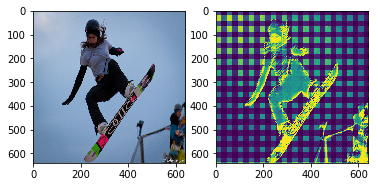

In [67]:
########################################
######## SEE RESULTS of TRAIN ##########
########################################

"""
Image ids of train
[214972, 445425, 222024, 238712, 199990, 235486, 462283,  77889,
       561337, 473801,  48743, 516488, 548964, 200814, 458857, 400093,
       548843, 294074, 360246, 556955]
"""

img_id = 556955
cat_id = 1
cc = cc1 #or cc2 for val
master_df = train_master_df # or val_master_df

mask_pred = check_pred_img_for_img_id(model, img_id, 
                          cc, co_ob, cat_id,
                          img_path_df, master_df)

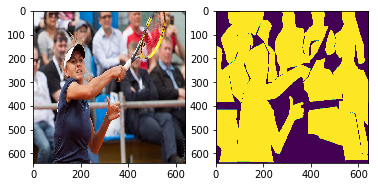

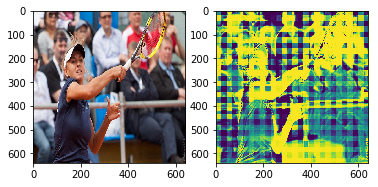

In [75]:
########################################
######## SEE RESULTS of VAL ############
########################################
"""
[486438, 234526, 175251, 518770,   5060, 397303, 229216, 541123,
        13177, 167122, 471756, 199395, 117645, 330369, 420840, 251140,
        78915, 149770, 386352, 567011]
"""
img_id = 386352
cat_id = 1
cc = cc2
master_df = val_master_df

mask_pred = check_pred_img_for_img_id(model, img_id, 
                          cc, co_ob, cat_id,
                          img_path_df, master_df)

In [0]:
def loop_plot_and_check_pred(model, img_id_list,
                          cc, co_ob, cat_id,
                          img_path_df, master_df):
  
  for i in img_id_list:
    # print(i)
    mask_pred = check_pred_img_for_img_id(model, i, 
                            cc, co_ob, cat_id,
                            img_path_df, master_df)

cat_id = 1
# cc = cc1 # cc1 or cc2 for val
# master_df = train_master_df  #  train_master_df or val_master_df 



In [0]:
img_ids_list_train = r_df_train.iloc[20:30]['id'].values
loop

In [0]:
cat_id = 1
cc = cc1 # cc1 or cc2 for val
master_df = train_master_df  #  train_master_df or val_master_df 

r_df = r_df_val # r_df_train or r_df_val

img_ids = r_df.iloc[10:15]['id'].values
# print(img_ids)

for i in img_ids:
  # print(i)
  mask_pred = check_pred_img_for_img_id(model, i, 
                          cc, co_ob, cat_id,
                          img_path_df, master_df)

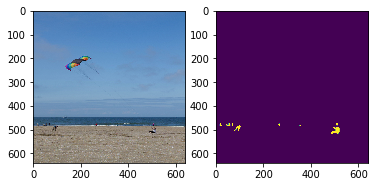

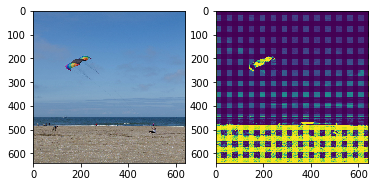

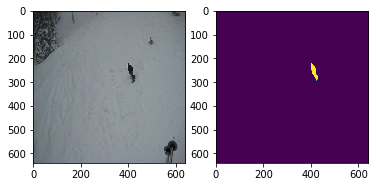

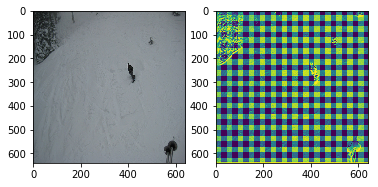

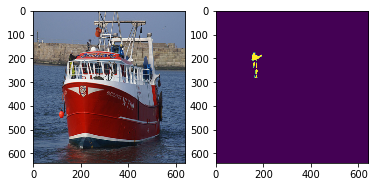

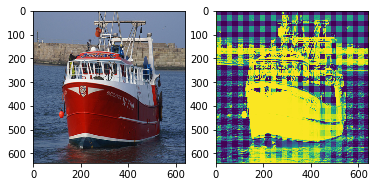

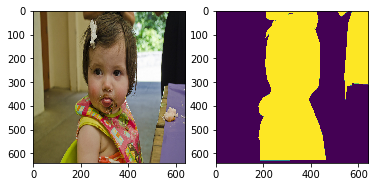

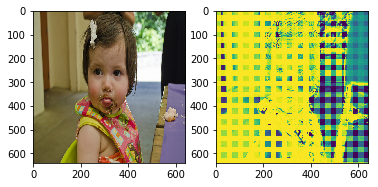

In [79]:
cat_id = 1
cc = cc2 # cc1 or cc2 for val
master_df = val_master_df  #  train_master_df or val_master_df 

r_df = r_df_val # r_df_train or r_df_val

img_ids = r_df.iloc[10:15]['id'].values
# print(img_ids)

for i in img_ids:
  # print(i)
  mask_pred = check_pred_img_for_img_id(model, i, 
                          cc, co_ob, cat_id,
                          img_path_df, master_df)

## Tensorboard

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip


LOG_DIR = './logs/fit/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')


! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

    
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt